# Tutorial

This tutorial implements three statistical inference methods in **"Efficient Inference for Nonparametric Hawkes Processes Using Auxiliary Latent Variables"**.

In the paper, we present an efficient Gibbs sampler, an EM algorithm and a mean-field variational inference algorithm with analytical expressions by using latent variable augmentation techniques. Please refer to the paper for more details. 

**Update:**

We provide a more elegant mean-field variational inference in the module `conjugate_np_hawkes_new` where the update of probabilistic branching matrix has a closed-form solution. 

In the original mean-field variational inference, we first integrate out the P\'{o}lya-Gamma random variable $\mathbf{\omega}$ and then take expectation of the logarithm of the joint distribution (without $\mathbf{\omega}$) to compute the optimal density for branching matrix. This results in $\tilde{\mu}(t_i)=\tilde{\lambda}_\mu^*e^{\mathbb{E}(\log\sigma(f(t_i)))}$, $\tilde{\phi}(\tau_{ij})=\tilde{\lambda}_\phi^*e^{\mathbb{E}(\log\sigma(g(\tau_{ij})))}$ where $\mathbb{E}(\log\sigma(\cdot))$ has no closed-form solution and we have to resort to numerical methods. On the contrary, in the revised mean-field variational inference, we directly take expectation of the logarithm of the joint distribution (with $\mathbf{\omega}$) to compute the optimal density for branching matrix. After integrating out $\mathbf{\omega}$, we obtain
$$q(\mathbf{X})\propto\prod_{i=1}^N\left(\tilde{\lambda}_{\mu}^*\sigma(\tilde{f}(t_i))e^{(\bar{f}(t_i)-\tilde{f}(t_i))/2}\right)^{x_{ii}}\prod_{i=2}^N\prod_{j=1}^{i-1}\left(\tilde{\lambda}_{\phi}^*\sigma(\tilde{g}(\tau_{ij}))e^{(\bar{g}(\tau_{ij})-\tilde{g}(\tau_{ij}))/2}\right)^{x_{ij}},$$
which is a categorical distribution with
$$q(x_{ii}=1)=\frac{\tilde{\mu}(t_i)}{\tilde{\mu}(t_i)+\sum_{j=1}^{i-1}\tilde{\phi}(\tau_{ij})}\\
q(x_{ij}=1)=\frac{\tilde{\phi}(\tau_{ij})}{\tilde{\mu}(t_i)+\sum_{j=1}^{i-1}\tilde{\phi}(\tau_{ij})}$$
where $\tilde{\mu}(t_i)=\tilde{\lambda}_{\mu}^*\sigma(\tilde{f}(t_i))e^{(\bar{f}(t_i)-\tilde{f}(t_i))/2}$ and $\tilde{\phi}(\tau_{ij})=\tilde{\lambda}_{\phi}^*\sigma(\tilde{g}(\tau_{ij}))e^{(\bar{g}(\tau_{ij})-\tilde{g}(\tau_{ij}))/2}$. 

## Synthetic Data

From the `conjugate_np_hawkes_new` module, we import the `CNPHawkes` class. 

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns # for plot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False}) # set seaborn style
import matplotlib.pyplot as plt # for plot
from conjugate_np_hawkes_new import CNPHawkes
from scipy.stats import gamma
from scipy.stats import multivariate_normal
from scipy.special import expit

Let us load the training and test data. Here we take Case 3 in the paper for an example. 

In [57]:
data = pd.read_csv("./train_data.csv")
points_hawkes=data['0'].to_list()
data = pd.read_csv("./test_data.csv")
points_hawkes_test=data['0'].to_list()

The training and test data both have observation window $[0,T=100]$ and the support of influence function $T_\phi=6$. We assume that there are $10$ inducing points on $[0,T]$ uniformly for $\mu(t)$, and $10$ inducing points on $[0,T_\phi]$ uniformly for $\phi(\tau)$. We initialise an instance of CNPHawkes with these hyperparameters. 

In [58]:
T=100.0
T_test=100.0
T_phi=6.0
xi_mu=np.linspace(0,T,10)   # 10 inducing points on [0,T]
xi_phi=np.linspace(0,T_phi,10)   # 10 inducing points on [0, T_phi]

In [59]:
toy_model = CNPHawkes(xi_mu,xi_phi,T_phi)

We set the training and test data with their corresponding observation window.

In [60]:
toy_model.set_train_test_data(points_hawkes,T,points_hawkes_test,T_test)

## Gibbs Sampler

In this section, we implement the Gibbs sampler to sample from the posterior of parameters. Besides, we compute the training and test log-likelihood along iterations to show the convergence. The resulting posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ are plotted to compare to the ground truth. 

Let us set the hyperparameters for the kernels of Gaussian processes.  

In [164]:
theta0_mu=2.7
theta1_mu=0.005
noise_var_mu=0.0
theta0_phi=5.0
theta1_phi=5.0
noise_var_phi=0.0
toy_model.set_kernel_hyperparameters(theta0_mu,theta1_mu,noise_var_mu,theta0_phi,theta1_phi,noise_var_phi)

Let us run the Gibbs sampler. `num_pre_mu` and `num_pre_phi` are the number of prediction points on $\mu(t)$ and $\phi(\tau)$ respectively. 

In [166]:
mu_list,phi_list,lamda_mu_list,lamda_phi_list,logl_train_list,logl_test_list=\
toy_model.Gibbs(num_pre_mu=1000,num_pre_phi=1000,num_iter=500)

Let us show the convergence using log-likelihood along iterations. 

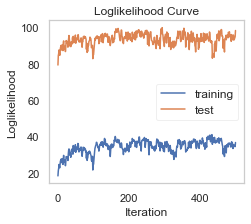

In [204]:
plt.figure(1,figsize=(3.5,3))
axs=plt.subplot(111)
axs.plot(range(len(logl_train_list_em)),logl_train_list,label='training')
axs.plot(range(len(logl_test_list_em)),logl_test_list,label='test')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Loglikelihood Curve',fontsize=12)
plt.legend(fontsize=12,framealpha =0.3)
plt.show()

The estimated posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ with the ground truth. 

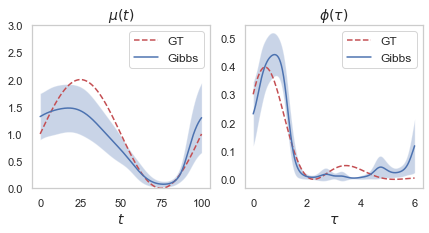

In [168]:
plt.figure(1,figsize=(7,3))
axs=plt.subplot(121)
axs.plot(np.linspace(0,T,100),np.sin(2*np.pi/100*np.linspace(0,T,100))+1,'r--',label='GT')
axs.plot(np.linspace(0,T,len(mu_list[0])),np.average(mu_list[-100:],axis=0),label='Gibbs')
axs.fill_between(np.linspace(0,T,len(mu_list[0])),np.average(mu_list[-100:],axis=0)-np.std(mu_list[-100:],axis=0),\
                 np.average(mu_list[-100:],axis=0)+np.std(mu_list[-100:],axis=0),alpha=0.3)
plt.ylim(0,3)
plt.xlabel(r'$t$',fontsize=14)
plt.title(r'$\mu(t)$',fontsize=14)
plt.legend(fontsize=12)

axs=plt.subplot(122)
axs.plot(np.linspace(0,T_phi,100),0.3*(np.sin(2*np.pi/3*np.linspace(0,6,100))+1)*np.exp(-0.7*np.linspace(0,6,100)),'r--',label='GT')
axs.plot(np.linspace(0,T_phi,len(phi_list[0])),np.average(phi_list[-100:],axis=0),label='Gibbs')
axs.fill_between(np.linspace(0,T_phi,len(phi_list[0])),np.average(phi_list[-100:],axis=0)-np.std(phi_list[-100:],axis=0),\
                 np.average(phi_list[-100:],axis=0)+np.std(phi_list[-100:],axis=0),alpha=0.3)
plt.xlabel(r'$\tau$',fontsize=14)
plt.title(r'$\phi(\tau)$',fontsize=14)
plt.legend(fontsize=12)
plt.show()

## EM Algorithm

In this section, we implement the EM algorithm to evaluate the MAP estimate of parameters. Besides, we compute the training and test log-likelihood along iterations to show the convergence. The resulting baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ are plotted to compare to the ground truth. 

Let us set the hyperparameters for the kernels of Gaussian processes. 

In [25]:
theta0_mu=2.0
theta1_mu=0.002
noise_var_mu=0.0
theta0_phi=5.0
theta1_phi=5.0
noise_var_phi=0.0
toy_model.set_kernel_hyperparameters(theta0_mu,theta1_mu,noise_var_mu,theta0_phi,theta1_phi,noise_var_phi)

Let us run the EM algorithm. `num_gq_mu` and `num_gq_phi` are the number of Gaussian quadrature nodes on $[0,T]$ and $[0,T_\phi]$ respectively; `num_pre_mu` and `num_pre_phi` are the number of prediction points on $\mu(t)$ and $\phi(\tau)$ respectively. 

In [26]:
mu_list_em,phi_list_em,lamda_mu_list_em,lamda_phi_list_em,logl_train_list_em,logl_test_list_em=\
toy_model.EM(num_gq_mu=100,num_gq_phi=100,num_pre_mu=1000,num_pre_phi=1000,num_iter=500)

Let us show the convergence using log-likelihood along iterations. 

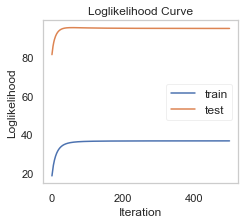

In [27]:
plt.figure(1,figsize=(3.5,3))
axs=plt.subplot(111)
axs.plot(range(len(logl_train_list_em)),logl_train_list_em,label='train')
axs.plot(range(len(logl_test_list_em)),logl_test_list_em,label='test')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Loglikelihood Curve',fontsize=12)
plt.legend(fontsize=12,framealpha =0.3)
plt.show()

The estimated baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ with the ground truth. 

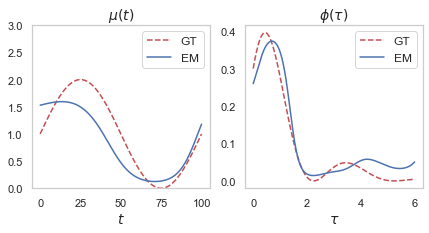

In [28]:
plt.figure(1,figsize=(7,3))
axs=plt.subplot(121)
axs.plot(np.linspace(0,T,100),np.sin(2*np.pi/100*np.linspace(0,T,100))+1,'r--',label='GT')
axs.plot(np.linspace(0,T,len(mu_list_em[-1])),mu_list_em[-1],label='EM')
plt.ylim(0,3)
plt.xlabel(r'$t$',fontsize=14)
plt.title(r'$\mu(t)$',fontsize=14)
plt.legend(fontsize=12)

axs=plt.subplot(122)
axs.plot(np.linspace(0,T_phi,100),0.3*(np.sin(2*np.pi/3*np.linspace(0,6,100))+1)*np.exp(-0.7*np.linspace(0,6,100)),'r--',label='GT')
axs.plot(np.linspace(0,T_phi,len(phi_list_em[-1])),phi_list_em[-1],label='EM')
plt.xlabel(r'$\tau$',fontsize=14)
plt.title(r'$\phi(\tau)$',fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Mean-Field Variational Inference

In this section, we implement the mean-field algorithm to evaluate the approximated posterior of parameters. Besides, we compute the training and test log-likelihood (using mean) along iterations to show the convergence. The resulting posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ are plotted to compare to the ground truth. 

Let us set the hyperparameters for the kernels of Gaussian processes. 

In [94]:
theta0_mu=2.0
theta1_mu=0.002
noise_var_mu=0.0
theta0_phi=3.0
theta1_phi=3.0
noise_var_phi=0.0
toy_model.set_kernel_hyperparameters(theta0_mu,theta1_mu,noise_var_mu,theta0_phi,theta1_phi,noise_var_phi)

Let us run the mean-field algorithm. `num_gq_mu` and `num_gq_phi` are the number of Gaussian quadrature nodes on $[0,T]$ and $[0,T_\phi]$ respectively; `num_pre_mu` and `num_pre_phi` are the number of prediction points on $\mu(t)$ and $\phi(\tau)$ respectively. 

In [95]:
%%time
g_mu_mean_list, g_mu_cov_list, g_phi_mean_list, g_phi_cov_list, alpha_mu_list, alpha_phi_list, logl_train_list_mf, logl_test_list_mf\
=toy_model.MF(num_gq_mu=100,num_gq_phi=100,num_pre_mu=1000,num_pre_phi=1000,num_iter=500)

Wall time: 5min 24s


Let us show the convergence using log-likelihood along iterations. 

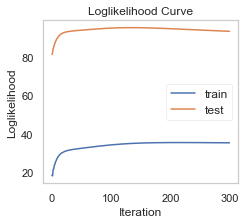

In [98]:
plt.figure(1,figsize=(3.5,3))
axs=plt.subplot(111)
axs.plot(range(len(logl_train_list_mf)),logl_train_list_mf,label='train')
axs.plot(range(len(logl_test_list_mf)),logl_test_list_mf,label='test')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Loglikelihood Curve',fontsize=12)
plt.legend(fontsize=12,framealpha =0.3)
plt.show()

The estimated posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ with the ground truth. 

Let us take 100 samples of $\mu(t)$ and $\phi(\tau)$ from the posterior.

In [100]:
lamda_mu_mf = gamma(a=alpha_mu_list[-1], scale=1/T).rvs(size=100)
lamda_phi_mf = gamma(a=alpha_phi_list[-1], scale=1/len(points_hawkes)/T_phi).rvs(size=100)
g_mu_mf = multivariate_normal(g_mu_mean_list[-1],g_mu_cov_list[-1]+np.eye(1000)*0.0001).rvs(size=100)
g_phi_mf = multivariate_normal(g_phi_mean_list[-1],g_phi_cov_list[-1]+np.eye(1000)*0.0001).rvs(size=100)

In [104]:
mu_mean_mf=np.average([lamda_mu_mf[i]*expit(g_mu_mf[i]) for i in range(100)],axis=0)
phi_mean_mf=np.average([lamda_phi_mf[i]*expit(g_phi_mf[i]) for i in range(100)],axis=0)
mu_lb_mf=mu_mean_mf-np.std([lamda_mu_mf[i]*expit(g_mu_mf[i]) for i in range(100)],axis=0)
mu_ub_mf=mu_mean_mf+np.std([lamda_mu_mf[i]*expit(g_mu_mf[i]) for i in range(100)],axis=0)
phi_lb_mf=phi_mean_mf-np.std([lamda_phi_mf[i]*expit(g_phi_mf[i]) for i in range(100)],axis=0)
phi_ub_mf=phi_mean_mf+np.std([lamda_phi_mf[i]*expit(g_phi_mf[i]) for i in range(100)],axis=0)

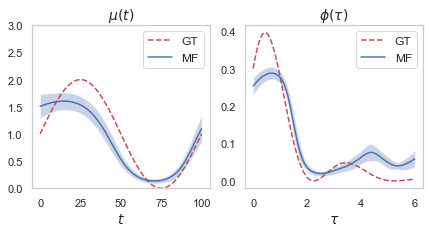

In [105]:
plt.figure(1,figsize=(7,3))
axs=plt.subplot(121)
axs.plot(np.linspace(0,T,100),np.sin(2*np.pi/100*np.linspace(0,T,100))+1,'r--',label='GT')
axs.plot(np.linspace(0,T,len(mu_mean_mf)),mu_mean_mf,label='MF')
axs.fill_between(np.linspace(0,T,len(mu_mean_mf)),mu_lb_mf,mu_ub_mf,alpha=0.3)
plt.ylim(0,3)
plt.xlabel(r'$t$',fontsize=14)
plt.title(r'$\mu(t)$',fontsize=14)
plt.legend(fontsize=12)

axs=plt.subplot(122)
axs.plot(np.linspace(0,T_phi,100),0.3*(np.sin(2*np.pi/3*np.linspace(0,6,100))+1)*np.exp(-0.7*np.linspace(0,6,100)),'r--',label='GT')
axs.plot(np.linspace(0,T_phi,len(phi_mean_mf)),phi_mean_mf,label='MF')
axs.fill_between(np.linspace(0,T_phi,len(phi_mean_mf)),phi_lb_mf,phi_ub_mf,alpha=0.3)
plt.xlabel(r'$\tau$',fontsize=14)
plt.title(r'$\phi(\tau)$',fontsize=14)
plt.legend(fontsize=12)
plt.show()